## Config

In [1]:
FS = 50.0 # Sampling rate in HZ
WIN_S, HOP_S = 2.0, 1.0 # Base window: 2s windown, 1s hop
OVERLAP = 0.5

# Directory
BASE_DIR = './datasets'
OUT_DIR = './out'
CLEANED_DIR = OUT_DIR + "/cleaned"
MODEL_DIR = OUT_DIR + '/models'
print("Checking directories...")
DIRS = [BASE_DIR, OUT_DIR, CLEANED_DIR, MODEL_DIR]
import os
for d in DIRS:
    if not os.path.exists(d):
        os.makedirs(d)
        print("✅ Created directory: " + d)
    else:
        print("✅ Directory exists: " + d)


Checking directories...
✅ Directory exists: ./datasets
✅ Directory exists: ./out
✅ Directory exists: ./out/cleaned
✅ Directory exists: ./out/models


## Utils

In [2]:
import numpy as np
import pandas as pd

def clean_file(path, fs=FS):
    try:
        df = read_csv(path)
        df = standardize_columns(df)
        df = coerce_numeric(df)
        df = add_timestamp(df, fs=fs)
        df = add_magnitude(df)
        
        preferred_cols = ['timestamp', 'unix_s', 'dt_s', 'subject',
                          'ax_mps2', 'ay_mps2', 'az_mps2',
                          'gx_rad_s', 'gy_rad_s', 'gz_rad_s',
                          'acc_mag', 'gyro_mag', 'label']
        cols = [c for c in preferred_cols if c in df.columns] + [c for c in df.columns if c not in preferred_cols]
        return df[cols]
        
    except Exception as e:
        print(f"❌ Error cleaning {path}: {e}")
        return None

def read_csv(path):
    """Robust CSV reader that handles various encodings and separators"""
    encodings = ["utf-8", "utf-8-sig", "cp874", "tis-620", "latin1"]
    seps = [",", ";", "\t", "|"]
    last_err = None
    
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep)
                # Handle comma-separated data in single column
                if df.shape[1] == 1 and df.iloc[:,0].astype(str).str.contains(",").mean() > 0.2:
                    df = pd.read_csv(path, encoding=enc)
                return df
            except Exception as e:
                last_err = e
    raise last_err

def standardize_columns(df):
    df = df.rename(columns={c: (c.strip()).lower() for c in df.columns})
    col_map = {
        "samplingtime": "unix_s",
        "subject": "subject",
        "accelerationx": "ax_mps2", "accelerationy": "ay_mps2", "accelerationz": "az_mps2",
        "gyrox": "gx_rad_s", "gyroy": "gy_rad_s", "gyroz": "gz_rad_s",
        "activity": "label"
    }
    
    df = df.rename(columns={k:v for k,v in col_map.items() if k in df.columns})
    
    unused_cols = ['magneticfieldx', 'magneticfieldy', 'magneticfieldz', 'latitude', 'longitude', 'duration', 'durations']
    df = df.drop(columns=[c for c in unused_cols if c in df.columns], errors='ignore')

    return df
    
def coerce_numeric(df):
    """Convert object columns to numeric, handling various formats"""
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    for c in obj_cols:
        if c == 'label':
            continue
        s = df[c].astype(str).str.strip().str.replace(",", "", regex=False)
        df[c] = pd.to_numeric(s, errors="coerce")
    return df

def add_timestamp(df, fs=FS, tz="Asia/Bangkok"):
    if 'unix_s' in df.columns:
        ts = pd.to_numeric(df["unix_s"], errors="coerce")
        t_utc = pd.to_datetime(ts, unit="s", utc=True, errors="coerce")
        df["timestamp"] = t_utc.dt.tz_convert(tz)
    
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp").reset_index(drop=True)
        df["dt_s"] = df["timestamp"].diff().dt.total_seconds()
    return df

def add_magnitude(df):
    if all(c in df.columns for c in ["ax_mps2", "ay_mps2", "az_mps2"]):
        df["acc_mag"] = np.sqrt(df["ax_mps2"]**2 + df["ay_mps2"]**2 + df["az_mps2"]**2)
    if all(c in df.columns for c in ["gx_rad_s", "gy_rad_s", "gz_rad_s"]):
        df["gyro_mag"] = np.sqrt(df["gx_rad_s"]**2 + df["gy_rad_s"]**2 + df["gz_rad_s"]**2)
    return df

In [27]:
print("Cleaning Datasets...")
import glob
all_csv = sorted([p for p in glob.glob(os.path.join(BASE_DIR, "*", "*.csv")) if OUT_DIR not in p])

cleaned_paths = []
failed_files = []

if len(all_csv) != 0:
    try :
        parts = []
        for i, path in enumerate(all_csv,1):
            filename = os.path.basename(path)
            print(f"Processing {i:2d}/{len(all_csv)}: {filename}")
            df = clean_file(path)
            
            if df is not None:
                df['source_file'] = filename
                parts.append(df)
                
        combined = pd.concat(parts, ignore_index=True)
        
        out_path = os.path.join(OUT_DIR, "combined_clean.csv")
        combined.to_csv(out_path, index=False)
        
        print(f"Saved to", out_path)
        del parts
    except Exception as e:
        print("failed to clean files :", e)
combined.head()

Cleaning Datasets...
Processing  1/35: downstairs_ed1.csv
Processing  2/35: downstairs_frank1.csv
Processing  3/35: downstairs_guy1.csv
Processing  4/35: downstairs_guy2.csv
Processing  5/35: downstairs_mike1.csv
Processing  6/35: downstairs_mike2.csv
Processing  7/35: downstairs_mike3.csv
Processing  8/35: downstairs_mon1.csv
Processing  9/35: downstairs_mon2.csv
Processing 10/35: downstairs_p1.csv
Processing 11/35: downstairs_p2.csv
Processing 12/35: idle_mike1.csv
Processing 13/35: run_ed1.csv
Processing 14/35: run_guy1.csv
Processing 15/35: run_mike1.csv
Processing 16/35: run_mon1.csv
Processing 17/35: run_mon2.csv
Processing 18/35: run_p1.csv
Processing 19/35: upstairs_ed1.csv
Processing 20/35: upstairs_frank1.csv
Processing 21/35: upstairs_frank2.csv
Processing 19/35: upstairs_ed1.csv
Processing 20/35: upstairs_frank1.csv
Processing 21/35: upstairs_frank2.csv
Processing 22/35: upstairs_guy1.csv
Processing 23/35: upstairs_guy2.csv
Processing 24/35: upstairs_mike1.csv
Processing 25

,timestamp,unix_s,dt_s,subject,ax_mps2,ay_mps2,az_mps2,gx_rad_s,gy_rad_s,gz_rad_s,acc_mag,gyro_mag,label,source_file
0,2025-09-30 17:50:47.487940073+07:00,1.759229e+09,NaN,5.0,1.141735,10.663924,-5.530157,0.335481,0.787187,0.327121,12.066709,0.916089,DOWNSTAIRS,downstairs_ed1.csv
1,2025-09-30 17:50:47.508320093+07:00,1.759229e+09,0.02038,5.0,2.127697,10.975469,-6.253355,1.299175,-1.492712,0.122435,12.809858,1.982684,DOWNSTAIRS,downstairs_ed1.csv
2,2025-09-30 17:50:47.528310061+07:00,1.759229e+09,0.01999,5.0,3.189974,10.146776,-3.866785,1.611506,-2.951892,-0.154953,11.317465,3.366694,DOWNSTAIRS,downstairs_ed1.csv
3,2025-09-30 17:50:47.547699928+07:00,1.759229e+09,0.01939,5.0,3.358466,8.897901,-3.374328,0.762063,-4.514754,-0.448919,10.091483,4.600573,DOWNSTAIRS,downstairs_ed1.csv
4,2025-09-30 17:50:47.568310022+07:00,1.759229e+09,0.02061,5.0,3.735852,8.160487,0.796521,0.844200,-4.736951,-0.732557,9.010249,4.867034,DOWNSTAIRS,downstairs_ed1.csv


## Windowing & Feature Extraction

In [28]:
# ใช้ไฟล์ combined_clean.csv แทน และจัดกลุ่มตาม label
print("🔄 Processing combined_clean.csv for windowing...")

# อ่าน combined_clean.csv
combined_path = os.path.join(OUT_DIR, "combined_clean.csv")
if os.path.exists(combined_path):
    print(f"📁 Loading: {combined_path}")
    df_combined = pd.read_csv(combined_path)
    print(f"📊 Combined data shape: {df_combined.shape}")
    
    # ตรวจสอบ labels ที่มี
    if 'label' in df_combined.columns:
        label_counts = df_combined['label'].value_counts()
        print(f"🏷️ Labels found: {dict(label_counts)}")
    else:
        print("❌ No 'label' column found!")
        df_combined = None
else:
    print(f"❌ File not found: {combined_path}")
    df_combined = None

🔄 Processing combined_clean.csv for windowing...
📁 Loading: ./out/combined_clean.csv
📊 Combined data shape: (272053, 14)
🏷️ Labels found: {'WALK': np.int64(81324), 'UPSTAIRS': np.int64(53313), 'RUN': np.int64(51496), 'IDLE': np.int64(43000), 'DOWNSTAIRS': np.int64(42920)}
📊 Combined data shape: (272053, 14)
🏷️ Labels found: {'WALK': np.int64(81324), 'UPSTAIRS': np.int64(53313), 'RUN': np.int64(51496), 'IDLE': np.int64(43000), 'DOWNSTAIRS': np.int64(42920)}


In [29]:
def create_windows_by_label(df, win_s=WIN_S, hop_s=HOP_S, fs=FS):
    """
    แบ่ง windows โดยจัดกลุ่มตาม label และ source_file
    """
    all_windows = []
    
    # จัดกลุ่มตาม source_file และ label
    grouped = df.groupby(['source_file', 'label'])
    
    print(f"📋 Processing {len(grouped)} groups (file-label combinations)...")
    
    for (source_file, label), group_data in grouped:
        print(f"  📁 {source_file} | 🏷️ {label} | {len(group_data)} samples")
        
        # เรียงตาม timestamp ถ้ามี
        if 'timestamp' in group_data.columns:
            group_data = group_data.sort_values('timestamp').reset_index(drop=True)
        elif 'unix_s' in group_data.columns:
            group_data = group_data.sort_values('unix_s').reset_index(drop=True)
        
        # สร้าง windows สำหรับกลุ่มนี้
        windows = create_windows_from_group(group_data, win_s, hop_s, fs, source_file, label)
        if windows:
            all_windows.extend(windows)
            print(f"    ✅ Created {len(windows)} windows")
    
    dfw = pd.DataFrame(all_windows)
    # เก็บ label ไว้สำหรับ threshold analysis
    return dfw

def create_windows_from_group(df_group, win_s, hop_s, fs, source_file, label):
    """
    สร้าง windows จากกลุ่มข้อมูลที่มี label เดียวกัน
    """
    win_samples = int(win_s * fs)
    hop_samples = int(hop_s * fs)
    
    # คอลัมน์ sensor ที่ใช้
    sensor_cols = ['ax_mps2', 'ay_mps2', 'az_mps2', 'gx_rad_s', 'gy_rad_s', 'gz_rad_s', 'acc_mag', 'gyro_mag']
    available_cols = [col for col in sensor_cols if col in df_group.columns]
    
    windows = []
    n_samples = len(df_group)
    
    # ต้องมีข้อมูลเพียงพอสำหรับอย่างน้อย 1 window
    if n_samples < win_samples:
        print(f"    ⚠️ Not enough samples ({n_samples} < {win_samples}) for label '{label}'")
        return windows
    
    for start_idx in range(0, n_samples - win_samples + 1, hop_samples):
        end_idx = start_idx + win_samples
        window_data = df_group.iloc[start_idx:end_idx]
        
        # ตรวจสอบว่า window นี้มี label เดียวกันทั้งหมดหรือไม่
        unique_labels = window_data['label'].unique()
        if len(unique_labels) > 1:
            # ถ้ามีหลาย label ใน window ให้ข้าม
            continue
        
        # สร้าง features
        features = {}
        
        # Metadata
        features['source_file'] = source_file
        features['label'] = label  # เก็บ label ไว้
        features['window_start_idx'] = start_idx
        features['window_end_idx'] = end_idx
        
        # Timestamp features
        if 'timestamp' in window_data.columns:
            features['start_time'] = window_data['timestamp'].iloc[0]
            features['end_time'] = window_data['timestamp'].iloc[-1]
        if 'unix_s' in window_data.columns:
            features['start_unix'] = window_data['unix_s'].iloc[0]
            features['end_unix'] = window_data['unix_s'].iloc[-1]
        
        # Subject ถ้ามี
        if 'subject' in window_data.columns:
            features['subject'] = window_data['subject'].iloc[0]
        
        # คำนวณ statistical features
        for col in available_cols:
            if col in window_data.columns:
                values = window_data[col].dropna()
                if len(values) > 0:
                    features[f'{col}_mean'] = values.mean()
                    features[f'{col}_std'] = values.std()
                    features[f'{col}_min'] = values.min()
                    features[f'{col}_max'] = values.max()
                    features[f'{col}_rms'] = np.sqrt((values ** 2).mean())
                    features[f'{col}_var'] = values.var()
                    features[f'{col}_range'] = values.max() - values.min()
                    features[f'{col}_median'] = values.median()
                    features[f'{col}_p25'] = values.quantile(0.25)
                    features[f'{col}_p75'] = values.quantile(0.75)
                    
                    # Zero crossing rate
                    if any(x in col for x in ['ax_mps2', 'ay_mps2', 'az_mps2']):
                        zero_crossings = np.sum(np.diff(np.sign(values - values.mean())) != 0)
                        features[f'{col}_zcr'] = zero_crossings / len(values) if len(values) > 1 else 0
        
        windows.append(features)
    
    return windows

In [30]:
# ประมวลผล windowing จาก combined_clean.csv
if df_combined is not None:
    print("\n🔄 Starting windowing process...")
    
    # สร้าง windows แยกตาม label
    features_by_label = create_windows_by_label(df_combined)
    
    if len(features_by_label) > 0:
        # บันทึกผลลัพธ์
        output_path = os.path.join(OUT_DIR, "features_base.csv")
        features_by_label.to_csv(output_path, index=False)
        
        print(f"\n✅ Windowing complete!")
        print(f"📁 Saved to: {output_path}")
        print(f"📊 Total windows: {len(features_by_label):,}")
        print(f"📊 Features per window: {features_by_label.shape[1]}")
        
        # สรุปผลตาม label
        if 'label' in features_by_label.columns:
            label_summary = features_by_label['label'].value_counts()
            print(f"\n🏷️ Windows per label:")
            for label, count in label_summary.items():
                print(f"   {label}: {count:,} windows")
        
        # แสดง sample ข้อมูล
        print(f"\n📋 Sample features:")
        std_cols = [col for col in features_by_label.columns if '_std' in col][:5]
        display_cols = ['source_file'] + std_cols
        print(features_by_label[display_cols].head())
        
        # แสดง statistical summary ของ SD
        if std_cols:
            print(f"\n📈 Standard Deviation Summary:")
            for col in std_cols:
                mean_std = features_by_label[col].mean()
                std_std = features_by_label[col].std()
                print(f"   {col}: μ={mean_std:.4f}, σ={std_std:.4f}")
        
    else:
        print("❌ No windows created!")
else:
    print("❌ Cannot process - combined_clean.csv not loaded")


🔄 Starting windowing process...
📋 Processing 35 groups (file-label combinations)...
  📁 downstairs_ed1.csv | 🏷️ DOWNSTAIRS | 7365 samples
📋 Processing 35 groups (file-label combinations)...
  📁 downstairs_ed1.csv | 🏷️ DOWNSTAIRS | 7365 samples
    ✅ Created 146 windows
  📁 downstairs_frank1.csv | 🏷️ DOWNSTAIRS | 7915 samples
    ✅ Created 146 windows
  📁 downstairs_frank1.csv | 🏷️ DOWNSTAIRS | 7915 samples
    ✅ Created 157 windows
  📁 downstairs_guy1.csv | 🏷️ DOWNSTAIRS | 4210 samples
    ✅ Created 157 windows
  📁 downstairs_guy1.csv | 🏷️ DOWNSTAIRS | 4210 samples
    ✅ Created 83 windows
  📁 downstairs_guy2.csv | 🏷️ DOWNSTAIRS | 2364 samples
    ✅ Created 83 windows
  📁 downstairs_guy2.csv | 🏷️ DOWNSTAIRS | 2364 samples
    ✅ Created 46 windows
  📁 downstairs_mike1.csv | 🏷️ DOWNSTAIRS | 4529 samples
    ✅ Created 46 windows
  📁 downstairs_mike1.csv | 🏷️ DOWNSTAIRS | 4529 samples
    ✅ Created 89 windows
  📁 downstairs_mike2.csv | 🏷️ DOWNSTAIRS | 2123 samples
    ✅ Created 41 windows

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_level_distributions(df_features, level_name, features_to_plot, group_mapping):
    """
    แสดงกราฟการกระจายของ features ในแต่ละ level
    """
    print(f"\n📊 {level_name} - Distribution Analysis")
    print("=" * 50)
    
    # สร้าง grouped labels ตาม mapping
    df_plot = df_features.copy()
    df_plot['group'] = df_plot['label'].map(group_mapping)
    
    # ตรวจสอบว่ามีข้อมูลที่ map ได้หรือไม่
    valid_data = df_plot.dropna(subset=['group'])
    if len(valid_data) == 0:
        print(f"❌ No valid data found for mapping: {group_mapping}")
        print(f"Available labels: {df_features['label'].unique()}")
        return []
    
    # นับจำนวนข้อมูลในแต่ละกลุ่ม
    group_counts = valid_data['group'].value_counts()
    print(f"Data distribution: {dict(group_counts)}")
    
    # เลือก features ที่มีอยู่
    available_features = [f for f in features_to_plot if f in df_features.columns]
    
    if not available_features:
        print("❌ No features available for plotting")
        return []
    
    # สร้างกราฟ
    n_features = len(available_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_features == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten() if n_features > 1 else [axes]
    else:
        axes = axes.flatten()
    
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']
    groups = valid_data['group'].unique()
    
    for i, feature in enumerate(available_features):
        ax = axes[i]
        
        # สถิติสำหรับแต่ละกลุ่ม
        print(f"\n📈 {feature}:")
        
        has_data = False
        for j, group in enumerate(groups):
            if pd.isna(group):
                continue
                
            data = valid_data[valid_data['group'] == group][feature].dropna()
            if len(data) > 0:
                # Plot histogram
                ax.hist(data, alpha=0.6, label=f'{group} (n={len(data)})', 
                       bins=30, color=colors[j % len(colors)])
                has_data = True
                
                # Print statistics
                print(f"   {group:15s}: μ={data.mean():.3f}, σ={data.std():.3f}, "
                      f"med={data.median():.3f}, range=[{data.min():.3f}, {data.max():.3f}]")
        
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.set_title(f'{feature} Distribution')
        
        # เพิ่ม legend เฉพาะเมื่อมีข้อมูล
        if has_data:
            ax.legend()
        ax.grid(True, alpha=0.3)
    
    # ซ่อน axes ที่ไม่ใช้
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'{level_name} - Feature Distributions', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return available_features

def analyze_hierarchical_classification(df_features):
    """
    วิเคราะห์การจำแนกแบบ Hierarchical ทั้ง 4 ระดับ
    """
    print("🏗️ Hierarchical Activity Classification Analysis")
    print("="*80)
    
    if 'label' not in df_features.columns:
        print("❌ No label column found!")
        return None
    
    # แสดง labels ที่มี
    label_counts = df_features['label'].value_counts()
    print(f"📊 Available Labels: {dict(label_counts)}")
    
    # ==============================================
    # LEVEL 1: IDLE vs MOTION
    # ==============================================
    level1_features = ['acc_mag_std', 'gyro_mag_std', 'acc_mag_mean', 'gyro_mag_mean', 'acc_mag_rms']
    level1_mapping = {
        'IDLE': 'IDLE',
        'WALK': 'MOTION', 
        'RUN': 'MOTION',
        'UPSTAIRS': 'MOTION',
        'DOWNSTAIRS': 'MOTION'
    }
    
    plot_level_distributions(df_features, "Level 1: IDLE vs MOTION", level1_features, level1_mapping)
    
    # ==============================================
    # LEVEL 2: RUN vs OTHERS (among MOTION)
    # ==============================================
    motion_data = df_features[df_features['label'].isin(['WALK', 'RUN', 'UPSTAIRS', 'DOWNSTAIRS'])]
    
    level2_features = ['acc_mag_std', 'acc_mag_rms', 'acc_mag_range', 'gyro_mag_std', 'gyro_mag_rms']
    level2_mapping = {
        'RUN': 'RUN',
        'WALK': 'OTHER_MOTION',
        'UPSTAIRS': 'OTHER_MOTION', 
        'DOWNSTAIRS': 'OTHER_MOTION'
    }
    
    if len(motion_data) > 0:
        plot_level_distributions(motion_data, "Level 2: RUN vs OTHER MOTION", 
                               level2_features, level2_mapping)
    
    # ==============================================
    # LEVEL 3: WALK vs STAIRS (among non-RUN) - Enhanced with Density & Kurtosis
    # ==============================================
    non_run_data = df_features[df_features['label'].isin(['WALK', 'UPSTAIRS', 'DOWNSTAIRS'])]
    
    # เพิ่ม features ใหม่สำหรับการแยก Walk vs Stairs
    level3_features = [
        # Original features
        'az_mps2_std', 'az_mps2_rms', 'acc_mag_std', 'az_mps2_range', 'az_mps2_mean',
        # New Kurtosis features (ความแหลม/แบนของ distribution)
        'az_mps2_kurtosis', 'acc_mag_kurtosis', 'ay_mps2_kurtosis',
        # New Density features (ความหนาแน่นของข้อมูล)
        'az_mps2_density_max', 'az_mps2_density_std', 'az_mps2_density_entropy',
        # Additional statistical features
        'az_mps2_skewness', 'az_mps2_iqr', 'az_mps2_mad'
    ]
    level3_mapping = {
        'WALK': 'WALK',
        'UPSTAIRS': 'STAIRS',
        'DOWNSTAIRS': 'STAIRS'
    }
    
    if len(non_run_data) > 0:
        walk_stairs_features = plot_level_distributions(non_run_data, "Level 3: WALK vs STAIRS", 
                               level3_features, level3_mapping)
        
        # วิเคราะห์เพิ่มเติมสำหรับ WALK vs STAIRS
        analyze_walk_stairs_separation(non_run_data, walk_stairs_features)
    
    # ==============================================
    # LEVEL 4: UPSTAIRS vs DOWNSTAIRS
    # ==============================================
    stairs_data = df_features[df_features['label'].isin(['UPSTAIRS', 'DOWNSTAIRS'])]
    
    level4_features = ['az_mps2_mean', 'acc_mag_mean', 'az_mps2_median', 'ax_mps2_mean', 'ay_mps2_mean', 
                      'az_mps2_p25', 'az_mps2_p75', 'gz_rad_s_mean']
    level4_mapping = {
        'UPSTAIRS': 'UPSTAIRS',
        'DOWNSTAIRS': 'DOWNSTAIRS'
    }
    
    if len(stairs_data) > 0:
        stairs_features = plot_level_distributions(stairs_data, "Level 4: UPSTAIRS vs DOWNSTAIRS", 
                                                 level4_features, level4_mapping)
        
        # วิเคราะห์เพิ่มเติมสำหรับ UPSTAIRS vs DOWNSTAIRS
        analyze_stairs_separation(stairs_data, stairs_features)
    
    return {
        'level1_features': level1_features,
        'level2_features': level2_features, 
        'level3_features': level3_features,
        'level4_features': level4_features
    }

def analyze_stairs_separation(stairs_data, features):
    """
    วิเคราะห์เฉพาะการแยก UPSTAIRS vs DOWNSTAIRS
    """
    print(f"\n🎯 Detailed UPSTAIRS vs DOWNSTAIRS Analysis")
    print("=" * 60)
    
    upstairs_data = stairs_data[stairs_data['label'] == 'UPSTAIRS']
    downstairs_data = stairs_data[stairs_data['label'] == 'DOWNSTAIRS']
    
    print(f"📊 Data counts: UPSTAIRS={len(upstairs_data)}, DOWNSTAIRS={len(downstairs_data)}")
    
    # วิเคราะห์ discriminative power
    discriminative_results = []
    
    for feature in features:
        if feature in stairs_data.columns:
            up_values = upstairs_data[feature].dropna()
            down_values = downstairs_data[feature].dropna()
            
            if len(up_values) > 0 and len(down_values) > 0:
                up_mean = up_values.mean()
                down_mean = down_values.mean()
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(up_values)-1)*up_values.var() + 
                                    (len(down_values)-1)*down_values.var()) / 
                                   (len(up_values) + len(down_values) - 2))
                
                cohens_d = abs(up_mean - down_mean) / (pooled_std + 1e-6)
                
                # Overlap coefficient
                overlap = min(up_values.max(), down_values.max()) - max(up_values.min(), down_values.min())
                total_range = max(up_values.max(), down_values.max()) - min(up_values.min(), down_values.min())
                overlap_ratio = overlap / (total_range + 1e-6) if total_range > 0 else 1.0
                
                discriminative_results.append({
                    'feature': feature,
                    'up_mean': up_mean,
                    'down_mean': down_mean,
                    'separation': abs(up_mean - down_mean),
                    'cohens_d': cohens_d,
                    'overlap_ratio': overlap_ratio,
                    'up_higher': up_mean > down_mean
                })
    
    # เรียงตาม Cohen's d
    discriminative_results.sort(key=lambda x: x['cohens_d'], reverse=True)
    
    print(f"\n🏆 Best Features for UPSTAIRS vs DOWNSTAIRS:")
    cohens_header = "Cohen's d"
    print(f"{'Feature':<20} {cohens_header:<10} {'Separation':<12} {'UP Mean':<10} {'DOWN Mean':<12} {'UP Higher'}")
    print("-" * 85)
    
    for result in discriminative_results[:8]:
        print(f"{result['feature']:<20} {result['cohens_d']:<10.3f} {result['separation']:<12.3f} "
              f"{result['up_mean']:<10.3f} {result['down_mean']:<12.3f} {result['up_higher']}")
    
    # แนะนำ threshold
    print(f"\n💡 Suggested Thresholds:")
    for result in discriminative_results[:5]:
        if result['cohens_d'] > 0.3:  # Medium effect size
            threshold = (result['up_mean'] + result['down_mean']) / 2
            if result['up_higher']:
                rule = f"if {result['feature']} > {threshold:.3f}: UPSTAIRS, else: DOWNSTAIRS"
            else:
                rule = f"if {result['feature']} < {threshold:.3f}: UPSTAIRS, else: DOWNSTAIRS"
            
            print(f"   {result['feature']}: {rule}")
    
    return discriminative_results

def analyze_walk_stairs_separation(walk_stairs_data, features):
    """
    วิเคราะห์เฉพาะการแยก WALK vs STAIRS โดยใช้ Density และ Kurtosis features
    """
    print(f"\n🚶 Detailed WALK vs STAIRS Analysis (Enhanced with Density & Kurtosis)")
    print("=" * 75)
    
    walk_data = walk_stairs_data[walk_stairs_data['label'] == 'WALK']
    stairs_data = walk_stairs_data[walk_stairs_data['label'].isin(['UPSTAIRS', 'DOWNSTAIRS'])]
    
    print(f"📊 Data counts: WALK={len(walk_data)}, STAIRS={len(stairs_data)}")
    
    # วิเคราะห์ discriminative power โดยเน้น Density และ Kurtosis features
    discriminative_results = []
    
    for feature in features:
        if feature in walk_stairs_data.columns:
            walk_values = walk_data[feature].dropna()
            stairs_values = stairs_data[feature].dropna()
            
            if len(walk_values) > 0 and len(stairs_values) > 0:
                walk_mean = walk_values.mean()
                stairs_mean = stairs_values.mean()
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(walk_values)-1)*walk_values.var() + 
                                    (len(stairs_values)-1)*stairs_values.var()) / 
                                   (len(walk_values) + len(stairs_values) - 2))
                
                cohens_d = abs(walk_mean - stairs_mean) / (pooled_std + 1e-6)
                
                # ระบุประเภท feature
                feature_type = "Original"
                if "kurtosis" in feature:
                    feature_type = "🔸 Kurtosis"
                elif "density" in feature:
                    feature_type = "🔹 Density"
                elif "skewness" in feature or "iqr" in feature or "mad" in feature:
                    feature_type = "📊 Enhanced"
                
                discriminative_results.append({
                    'feature': feature,
                    'feature_type': feature_type,
                    'walk_mean': walk_mean,
                    'stairs_mean': stairs_mean,
                    'separation': abs(walk_mean - stairs_mean),
                    'cohens_d': cohens_d,
                    'walk_higher': walk_mean > stairs_mean
                })
    
    # เรียงตาม Cohen's d
    discriminative_results.sort(key=lambda x: x['cohens_d'], reverse=True)
    
    print(f"\n🏆 Best Features for WALK vs STAIRS (Enhanced Analysis):")
    cohens_header = "Cohen's d"
    print(f"{'Feature':<25} {'Type':<12} {cohens_header:<10} {'Separation':<12} {'WALK Mean':<12} {'STAIRS Mean':<12} {'WALK Higher'}")
    print("-" * 110)
    
    for result in discriminative_results[:15]:  # แสดงมากขึ้นเพื่อดู new features
        print(f"{result['feature']:<25} {result['feature_type']:<12} {result['cohens_d']:<10.3f} {result['separation']:<12.3f} "
              f"{result['walk_mean']:<12.3f} {result['stairs_mean']:<12.3f} {result['walk_higher']}")
    
    # แยกแสดง top features ตามประเภท
    print(f"\n🎯 Top Features by Type:")
    
    # Top Kurtosis features
    kurtosis_features = [r for r in discriminative_results if "kurtosis" in r['feature']]
    if kurtosis_features:
        print(f"\n🔸 Best Kurtosis Features:")
        for result in kurtosis_features[:3]:
            print(f"   {result['feature']:<25}: Cohen's d = {result['cohens_d']:.3f}")
    
    # Top Density features  
    density_features = [r for r in discriminative_results if "density" in r['feature']]
    if density_features:
        print(f"\n🔹 Best Density Features:")
        for result in density_features[:3]:
            print(f"   {result['feature']:<25}: Cohen's d = {result['cohens_d']:.3f}")
    
    # แนะนำ threshold สำหรับ top features
    print(f"\n💡 Suggested Thresholds for WALK vs STAIRS:")
    for result in discriminative_results[:8]:
        if result['cohens_d'] > 0.2:  # Lower threshold เพื่อดู new features
            threshold = (result['walk_mean'] + result['stairs_mean']) / 2
            if result['walk_higher']:
                rule = f"if {result['feature']} > {threshold:.3f}: WALK, else: STAIRS"
            else:
                rule = f"if {result['feature']} < {threshold:.3f}: WALK, else: STAIRS"
            
            print(f"   {result['feature']}: {rule}")
    
    # สรุปผลของ new features
    new_features = [r for r in discriminative_results if r['feature_type'] != "Original"]
    if new_features:
        avg_cohens_new = np.mean([r['cohens_d'] for r in new_features])
        original_features = [r for r in discriminative_results if r['feature_type'] == "Original"]
        avg_cohens_original = np.mean([r['cohens_d'] for r in original_features]) if original_features else 0
        
        print(f"\n📈 Feature Performance Summary:")
        print(f"   New Features (Density/Kurtosis) avg Cohen's d: {avg_cohens_new:.3f}")
        print(f"   Original Features avg Cohen's d:               {avg_cohens_original:.3f}")
        
        if avg_cohens_new > avg_cohens_original:
            print(f"   ✅ New features improve WALK vs STAIRS separation!")
        else:
            print(f"   ⚠️ Original features still perform better")
    
    return discriminative_results


🔍 Checking current labels...

🚀 Starting Hierarchical Classification Analysis...
🏗️ Hierarchical Activity Classification Analysis
📊 Available Labels: {'WALK': np.int64(1617), 'UPSTAIRS': np.int64(1051), 'RUN': np.int64(1021), 'IDLE': np.int64(859), 'DOWNSTAIRS': np.int64(842)}

📊 Level 1: IDLE vs MOTION - Distribution Analysis
Data distribution: {'MOTION': np.int64(4531), 'IDLE': np.int64(859)}

📈 acc_mag_std:
   MOTION         : μ=6.297, σ=3.277, med=4.960, range=[0.041, 16.054]
   IDLE           : μ=0.025, σ=0.016, med=0.021, range=[0.012, 0.232]

📈 gyro_mag_std:
   MOTION         : μ=1.200, σ=0.478, med=1.015, range=[0.024, 3.183]
   IDLE           : μ=0.014, σ=0.026, med=0.010, range=[0.004, 0.508]

📈 acc_mag_mean:
   MOTION         : μ=12.146, σ=2.600, med=10.995, range=[9.546, 22.464]
   IDLE           : μ=9.836, σ=0.002, med=9.836, range=[9.831, 9.864]

📈 gyro_mag_mean:
   MOTION         : μ=2.357, σ=0.894, med=1.951, range=[0.037, 5.179]
   IDLE           : μ=0.022, σ=0.016, me

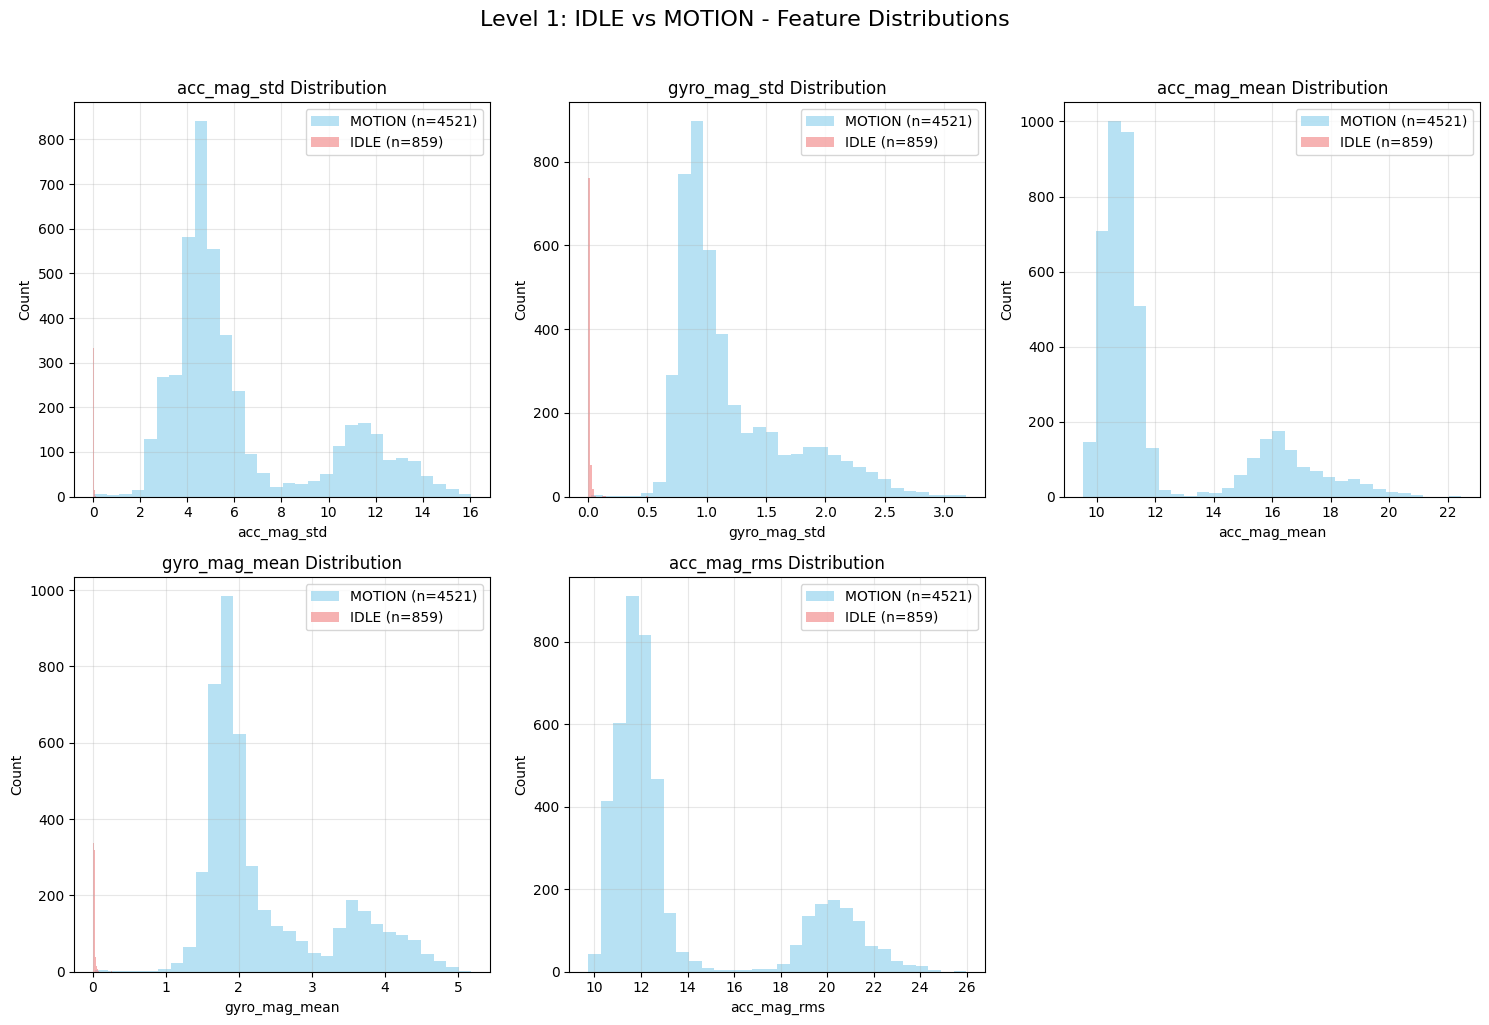


📊 Level 2: RUN vs OTHER MOTION - Distribution Analysis
Data distribution: {'OTHER_MOTION': np.int64(3510), 'RUN': np.int64(1021)}

📈 acc_mag_std:
   OTHER_MOTION   : μ=4.672, σ=1.243, med=4.610, range=[0.041, 13.789]
   RUN            : μ=11.867, σ=1.473, med=11.695, range=[6.650, 16.054]

📈 acc_mag_rms:
   OTHER_MOTION   : μ=11.813, σ=0.894, med=11.781, range=[9.733, 20.133]
   RUN            : μ=20.523, σ=1.313, med=20.392, range=[15.859, 25.980]

📈 acc_mag_range:
   OTHER_MOTION   : μ=25.762, σ=8.461, med=25.399, range=[0.192, 89.634]
   RUN            : μ=54.985, σ=8.024, med=54.846, range=[30.389, 82.313]

📈 gyro_mag_std:
   OTHER_MOTION   : μ=0.981, σ=0.211, med=0.939, range=[0.024, 1.860]
   RUN            : μ=1.948, σ=0.367, med=1.935, range=[1.242, 3.183]

📈 gyro_mag_rms:
   OTHER_MOTION   : μ=2.156, σ=0.391, med=2.085, range=[0.044, 3.487]
   RUN            : μ=4.329, σ=0.503, med=4.242, range=[3.081, 5.876]


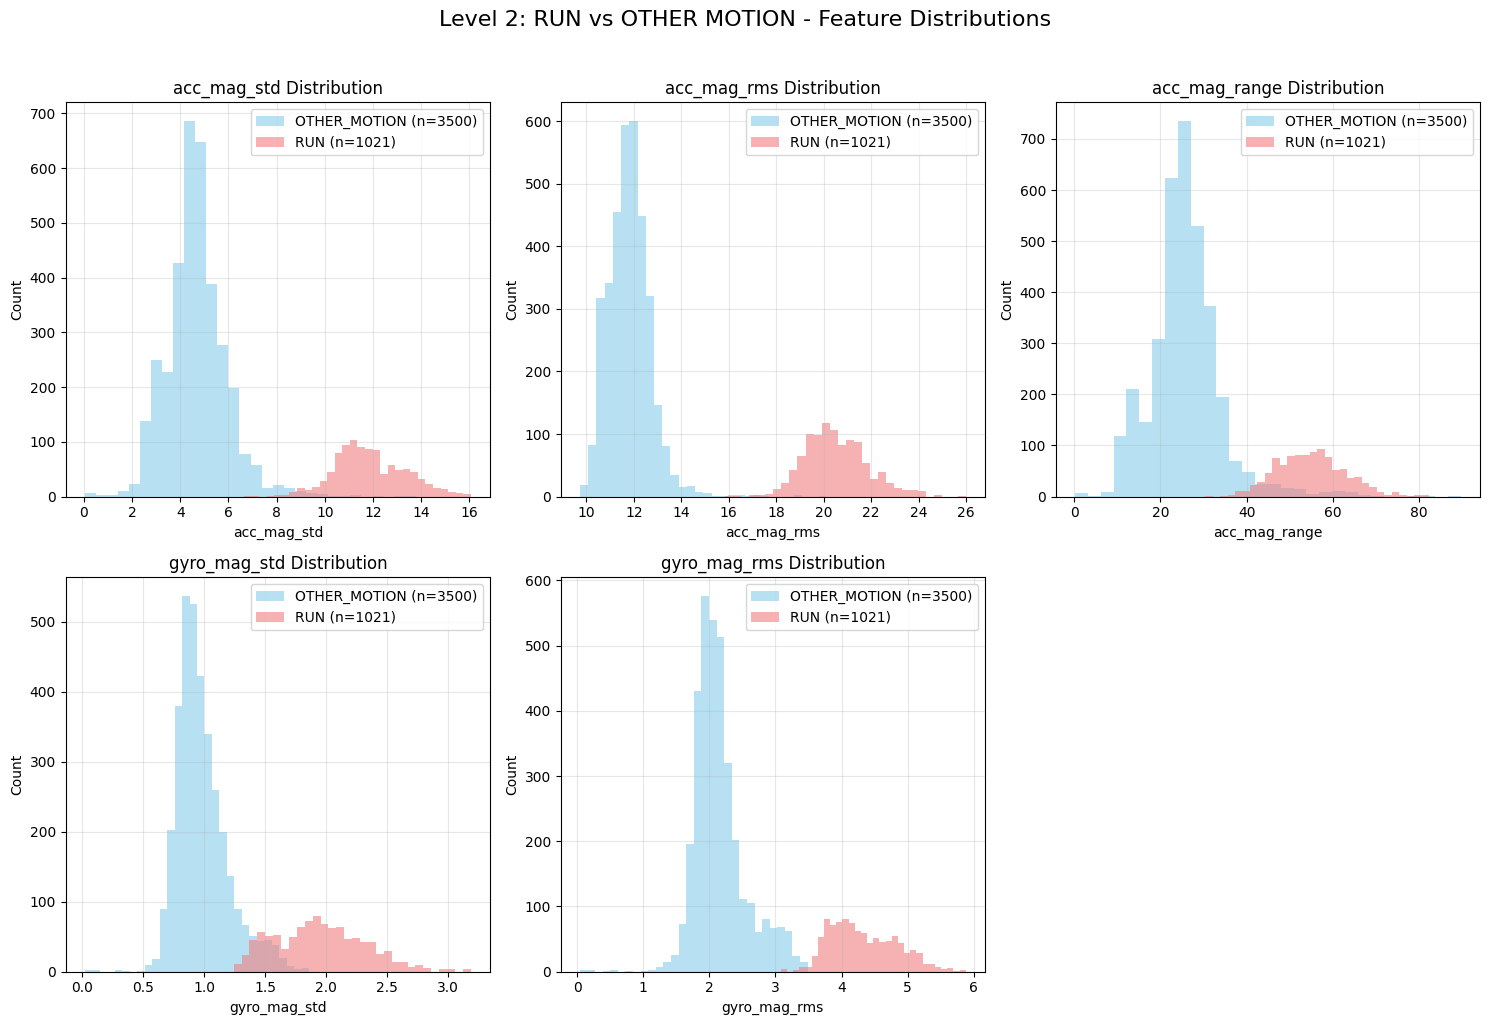


📊 Level 3: WALK vs STAIRS - Distribution Analysis
Data distribution: {'STAIRS': np.int64(1893), 'WALK': np.int64(1617)}

📈 az_mps2_std:
   STAIRS         : μ=3.476, σ=1.032, med=3.447, range=[1.002, 10.957]
   WALK           : μ=3.612, σ=0.921, med=3.468, range=[0.057, 6.808]

📈 az_mps2_rms:
   STAIRS         : μ=3.944, σ=1.093, med=3.975, range=[1.195, 11.035]
   WALK           : μ=3.676, σ=0.937, med=3.521, range=[0.758, 9.220]

📈 acc_mag_std:
   STAIRS         : μ=5.021, σ=1.357, med=4.880, range=[0.893, 13.789]
   WALK           : μ=4.266, σ=0.947, med=4.447, range=[0.041, 6.738]

📈 az_mps2_range:
   STAIRS         : μ=22.420, σ=8.830, med=20.973, range=[2.200, 111.023]
   WALK           : μ=21.907, σ=8.346, med=19.715, range=[0.272, 47.735]

📈 az_mps2_mean:
   STAIRS         : μ=-1.179, σ=1.532, med=-1.533, range=[-4.575, 3.828]
   WALK           : μ=-0.307, σ=0.738, med=-0.396, range=[-9.218, 1.464]


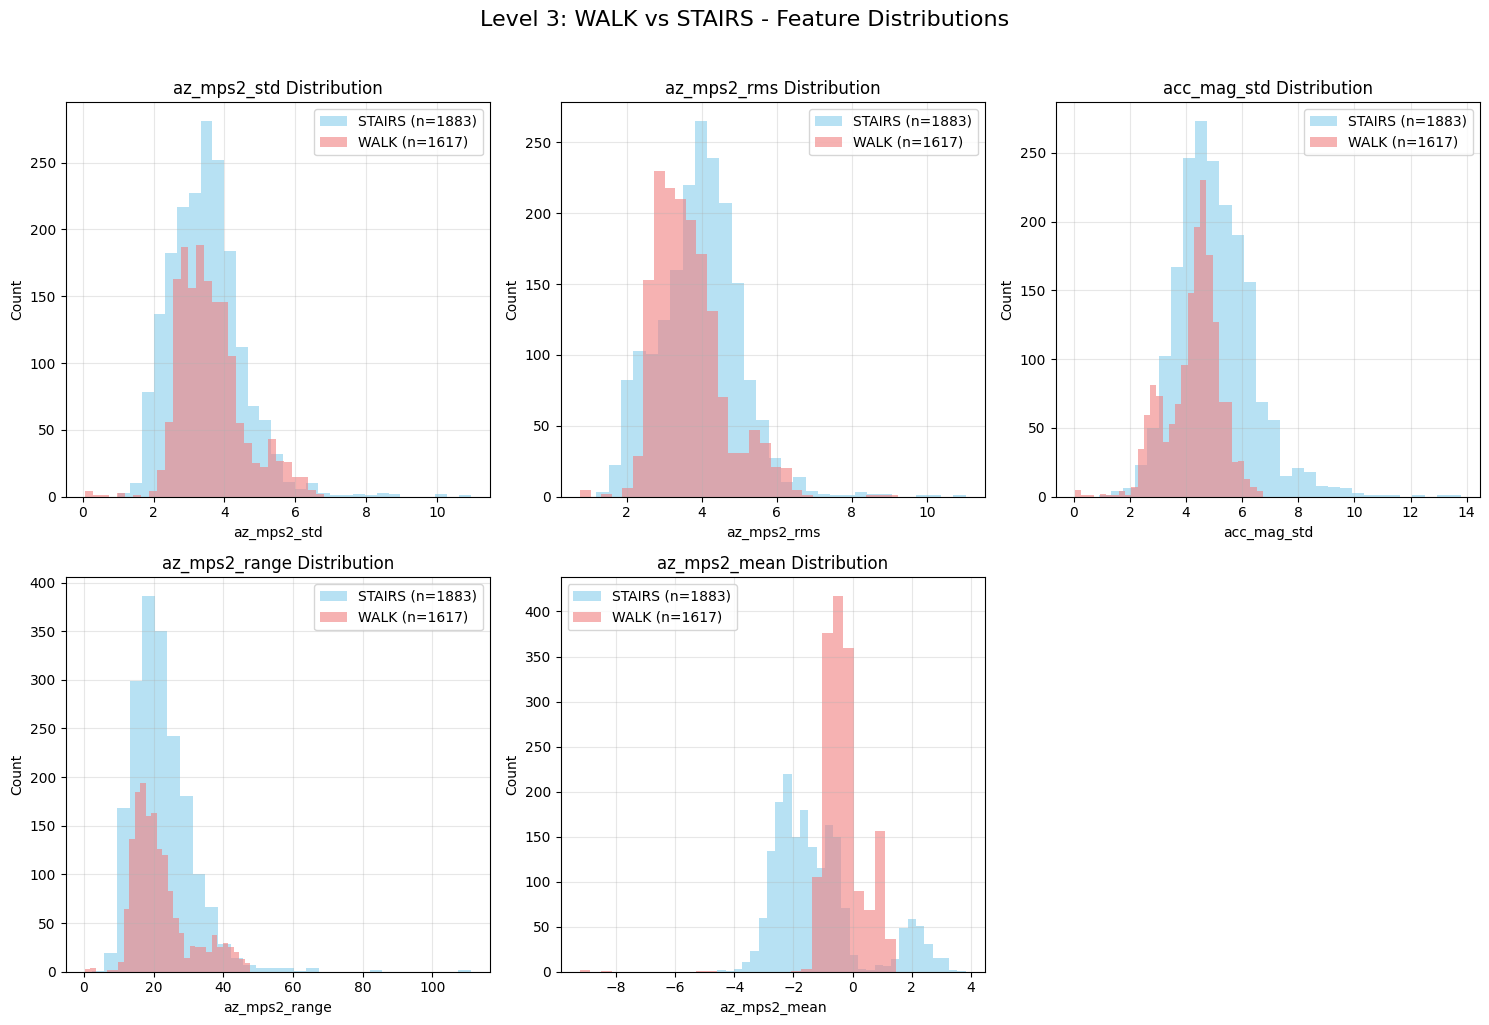


🚶 Detailed WALK vs STAIRS Analysis (Enhanced with Density & Kurtosis)
📊 Data counts: WALK=1617, STAIRS=1893

🏆 Best Features for WALK vs STAIRS (Enhanced Analysis):
Feature                   Type         Cohen's d  Separation   WALK Mean    STAIRS Mean  WALK Higher
--------------------------------------------------------------------------------------------------------------
az_mps2_mean              Original     0.708      0.871        -0.307       -1.179       True
acc_mag_std               Original     0.637      0.755        4.266        5.021        False
az_mps2_rms               Original     0.262      0.268        3.676        3.944        False
az_mps2_std               Original     0.138      0.136        3.612        3.476        True
az_mps2_range             Original     0.060      0.513        21.907       22.420       False

🎯 Top Features by Type:

💡 Suggested Thresholds for WALK vs STAIRS:
   az_mps2_mean: if az_mps2_mean > -0.743: WALK, else: STAIRS
   acc_mag_std: if

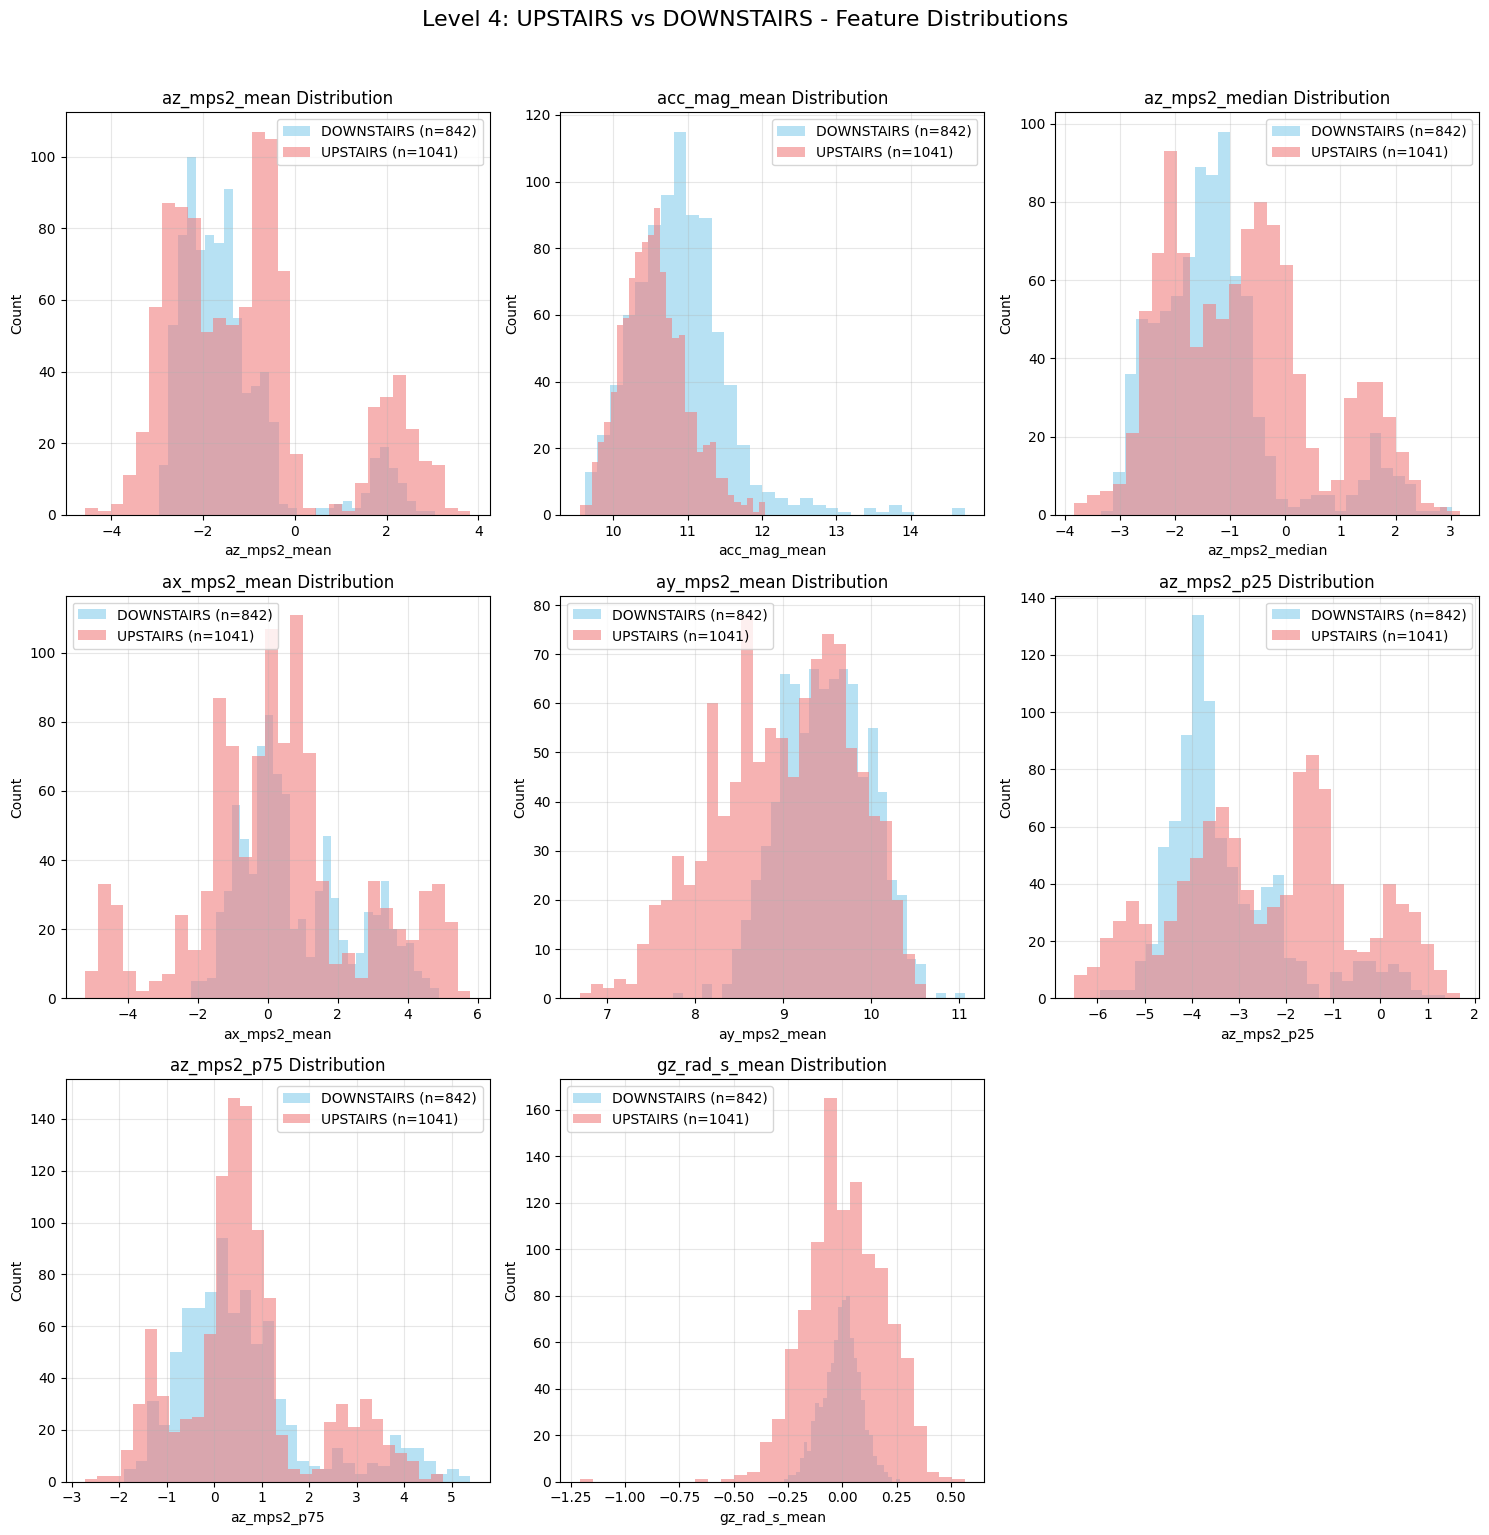


🎯 Detailed UPSTAIRS vs DOWNSTAIRS Analysis
📊 Data counts: UPSTAIRS=1051, DOWNSTAIRS=842

🏆 Best Features for UPSTAIRS vs DOWNSTAIRS:
Feature              Cohen's d  Separation   UP Mean    DOWN Mean    UP Higher
-------------------------------------------------------------------------------------
ay_mps2_mean         0.724      0.475        9.003      9.478        False
acc_mag_mean         0.621      0.334        10.560     10.894       False
az_mps2_p25          0.532      0.870        -2.409     -3.279       True
az_mps2_median       0.376      0.485        -0.771     -1.256       True
az_mps2_mean         0.258      0.392        -1.004     -1.395       True
ax_mps2_mean         0.247      0.508        0.323      0.831        False
gz_rad_s_mean        0.136      0.020        0.015      -0.005       True
az_mps2_p75          0.040      0.055        0.668      0.612        True

💡 Suggested Thresholds:
   ay_mps2_mean: if ay_mps2_mean < 9.241: UPSTAIRS, else: DOWNSTAIRS
   acc_mag_m

In [32]:
# Check and clean labels first
print("🔍 Checking current labels...")
print("\n🚀 Starting Hierarchical Classification Analysis...")

# รันการวิเคราะห์พร้อมกราฟ
hierarchy_info = analyze_hierarchical_classification(features_by_label)

print(f"\n✅ Hierarchical Analysis Complete!")
print(f"   📊 Total samples analyzed: {len(features_by_label):,}")
print(f"   🏷️ Labels: {sorted(features_by_label['label'].unique())}")

## Prepare Features for Model Training

In [33]:
# features_by_label -> DataFrame ที่ Windowing แล้ว

print("\n🔄 Preparing final dataset for modeling...")

# ลบ non freature columns ออก
non_feature_cols = ['source_file', 'label', 'window_start_idx', 'window_end_idx', 
                    'start_time', 'end_time', 'start_unix', 'end_unix', 'subject']
feature_cols = [c for c in features_by_label.columns if c not in non_feature_cols]
df = features_by_label[feature_cols + ['label']].dropna(subset=feature_cols).reset_index(drop=True)
print(f"removed non-feature columns, remaining features: {len(feature_cols)}")
print(f"dataset shape: {df.shape}")
# บันทึกไฟล์สำหรับ modeling
final_path = os.path.join(OUT_DIR, "features_trainable.csv")
df.to_csv(final_path, index=False)
print(f"📁 Saved to: {final_path}")


🔄 Preparing final dataset for modeling...
removed non-feature columns, remaining features: 83
dataset shape: (5380, 84)
📁 Saved to: ./out/features_trainable.csv
📁 Saved to: ./out/features_trainable.csv


## Split Dataset from Tranable to Train Test (70/30)

Feature matrix shape: (5380, 83)
Labels shape: (5380,)
Unique labels: ['DOWNSTAIRS' 'IDLE' 'RUN' 'UPSTAIRS' 'WALK']
Training set: (3766, 83), Test set: (1614, 83)

🎯 Training RandomForest with balanced class weights...
✅ Balanced Accuracy: 0.9909 (99.09%)
Classification Report:
              precision    recall  f1-score   support

  DOWNSTAIRS       0.99      0.99      0.99       253
        IDLE       0.99      1.00      0.99       258
         RUN       1.00      1.00      1.00       306
    UPSTAIRS       0.99      0.98      0.99       312
        WALK       0.99      0.99      0.99       485

    accuracy                           0.99      1614
   macro avg       0.99      0.99      0.99      1614
weighted avg       0.99      0.99      0.99      1614

Confusion Matrix:
✅ Balanced Accuracy: 0.9909 (99.09%)
Classification Report:
              precision    recall  f1-score   support

  DOWNSTAIRS       0.99      0.99      0.99       253
        IDLE       0.99      1.00      0.99  

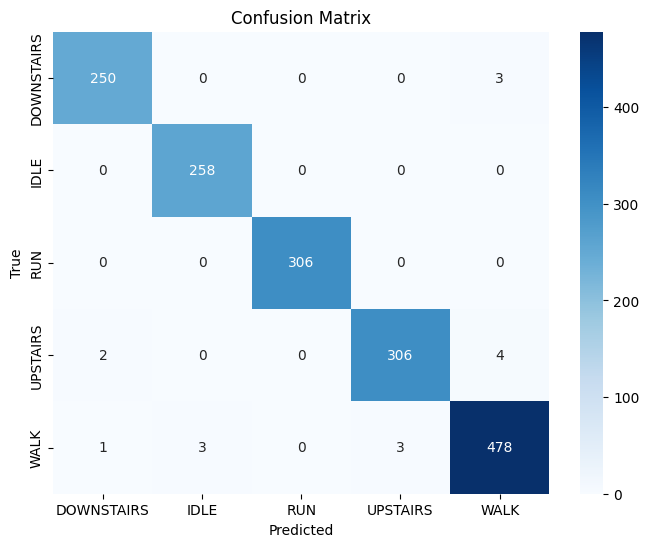

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data = read_csv("./out/features_trainable.csv")
data.head()

label_col = 'label'
if label_col not in data.columns:
    raise ValueError(f"No '{label_col}' column found!")

X = data.drop(columns=[label_col])
y = data[label_col]
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {y.unique()}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForestClassifier with class weighting
print("\n🎯 Training RandomForest with balanced class weights...")
clf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced',  # ✨ ปรับน้ำหนักให้ class ที่มีข้อมูลน้อย
    max_depth=20,             # จำกัดความลึกเพื่อป้องกัน overfitting
    min_samples_split=5,      # ต้องมีอย่างน้อย 5 samples ถึงจะแยก node
    min_samples_leaf=2        # แต่ละ leaf ต้องมีอย่างน้อย 2 samples
)
clf.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_scaled)

accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"✅ Balanced Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [35]:
import datetime as dt

import joblib


print("💾 Saving trained model...")

# Create model bundle with metadata
model_bundle = {
    "model": clf,
    "scaler": scaler,  # ✨ เพิ่ม StandardScaler เพื่อใช้ในการ inference
    "features": feature_cols,
    "label_col": label_col,
    "classes": list(y_train.unique()),
    "n_features": len(feature_cols),
    "train_samples": len(X_train),
    "test_samples": len(X_test) if X_test is not None else 0,
    "test_split": 0.30,
    "random_state": 42,
    "trained_at": dt.datetime.now().isoformat(timespec="seconds"),
    "model_type": "RandomForestClassifier",
    "model_params": clf.get_params()
}

# Add test accuracy if available
if X_test is not None and len(X_test) > 0:
    model_bundle["test_accuracy"] = accuracy

# Save model
model_path = os.path.join(MODEL_DIR, "rf_5cls.joblib")
joblib.dump(model_bundle, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📋 Model bundle contains:")
print(f"   - Trained RandomForest model")
print(f"   - StandardScaler for feature normalization")
print(f"   - {len(feature_cols)} feature names")
print(f"   - {len(model_bundle['classes'])} class labels")
print(f"   - Training metadata and parameters")
if X_test is not None:
    print(f"   - Test accuracy: {accuracy:.4f}")

💾 Saving trained model...
✅ Model saved to: ./out/models/rf_5cls.joblib
📋 Model bundle contains:
   - Trained RandomForest model
   - StandardScaler for feature normalization
   - 83 feature names
   - 5 class labels
   - Training metadata and parameters
   - Test accuracy: 0.9909


## Convert to ONNX

In [36]:
# Optional: Export to ONNX for mobile deployment
try:
    print("📱 Exporting model to ONNX format...")
    
    try:
        from skl2onnx import convert_sklearn
        from skl2onnx.common.data_types import FloatTensorType
        import onnx
    except ImportError:
        print("⚠️  skl2onnx not installed. Run: pip install skl2onnx")
        print("   Skipping ONNX export...")
    else:
        os.makedirs(MODEL_DIR, exist_ok=True)

        # ✨ เพิ่ม scaler parameters สำหรับ mobile inference
        mobile_bundle = {
            "classes": model_bundle["classes"],
            "features": feature_cols,
            "scaler_mean": scaler.mean_.tolist(),  # mean ของแต่ละ feature
            "scaler_scale": scaler.scale_.tolist(),  # std ของแต่ละ feature
            "trained_at": model_bundle["trained_at"],
            "test_accuracy": model_bundle.get("test_accuracy", "N/A")
        }

        import json
        with open(os.path.join(MODEL_DIR, "rf_5cls.meta.json"), "w") as f:
            json.dump(mobile_bundle, f, ensure_ascii=False, indent=2)

        print(f"✅ Mobile metadata saved to: {MODEL_DIR}/rf_5cls.meta.json")
        print(f"   📊 Scaler parameters exported: {len(scaler.mean_)} features")
        # Convert to ONNX
        initial_types = [("input", FloatTensorType([None, len(feature_cols)]))]
        options = {id(clf): {"zipmap": False}}  # Disable ZipMap for simpler output
        
        onnx_model = convert_sklearn(
            clf,
            initial_types=initial_types,
            options=options,
            target_opset=17
        )
        
        # Rename outputs for clarity
        onnx_model.graph.output[0].name = "label"
        onnx_model.graph.output[1].name = "probabilities"
        
        # Save ONNX model
        onnx_path = os.path.join(MODEL_DIR, "rf_5cls.onnx")
        onnx.save(onnx_model, onnx_path)
        
        print(f"✅ ONNX model saved to: {onnx_path}")
        print(f"   Output names: {[o.name for o in onnx_model.graph.output]}")
        print(f"   Input shape: [batch_size, {len(feature_cols)}]")
        
except Exception as e:
    print(f"❌ ONNX export failed: {e}")
    print("   Continuing without ONNX export...")

📱 Exporting model to ONNX format...
✅ Mobile metadata saved to: ./out/models/rf_5cls.meta.json
   📊 Scaler parameters exported: 83 features
✅ ONNX model saved to: ./out/models/rf_5cls.onnx
   Output names: ['label', 'probabilities']
   Input shape: [batch_size, 83]
✅ ONNX model saved to: ./out/models/rf_5cls.onnx
   Output names: ['label', 'probabilities']
   Input shape: [batch_size, 83]


In [37]:
# 📊 วิเคราะห์การกระจายของข้อมูล Training
print("=" * 80)
print("📊 TRAINING DATA ANALYSIS")
print("=" * 80)

# โหลด trainable features
trainable_path = os.path.join(OUT_DIR, 'features_trainable.csv')
if os.path.exists(trainable_path):
    train_data = pd.read_csv(trainable_path)
    
    print(f"\n📁 Total samples: {len(train_data):,}")
    print(f"📁 Total features: {len(train_data.columns)-1}")
    
    # วิเคราะห์การกระจายของแต่ละ label
    label_counts = train_data['label'].value_counts().sort_index()
    total = len(train_data)
    
    print(f"\n🏷️ Label Distribution:")
    print("-" * 70)
    print(f"{'Label':<15} {'Count':>8} {'Percentage':>12} {'Bar':>20}")
    print("-" * 70)
    
    max_count = label_counts.max()
    for label, count in label_counts.items():
        percentage = (count / total) * 100
        bar_length = int((count / max_count) * 20)
        bar = '█' * bar_length
        print(f"{label:<15} {count:>8,} {percentage:>11.2f}% {bar:>20}")
    
    print("-" * 70)
    
    # คำนวณ Imbalance Ratio
    min_count = label_counts.min()
    max_count = label_counts.max()
    imbalance_ratio = max_count / min_count
    
    print(f"\n📈 Balance Analysis:")
    print(f"   Min samples: {min_count:,} ({label_counts.idxmin()})")
    print(f"   Max samples: {max_count:,} ({label_counts.idxmax()})")
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    # ประเมินสถานะ
    if imbalance_ratio <= 1.5:
        status = "✅ EXCELLENT - Balanced dataset"
        recommendation = "No balancing needed"
    elif imbalance_ratio <= 2.0:
        status = "👍 GOOD - Slightly imbalanced"
        recommendation = "Consider using class_weight='balanced'"
    elif imbalance_ratio <= 3.0:
        status = "⚠️ FAIR - Moderately imbalanced"
        recommendation = "Use class_weight='balanced' or SMOTE"
    else:
        status = "❌ POOR - Highly imbalanced"
        recommendation = "Must use SMOTE or collect more data for minority classes"
    
    print(f"\n{status}")
    print(f"   Recommendation: {recommendation}")
    
    # วิเคราะห์ว่าแต่ละ class มีข้อมูลเพียงพอหรือไม่
    print(f"\n📋 Data Sufficiency per Class:")
    print("-" * 70)
    
    for label, count in label_counts.items():
        if count >= 2000:
            status = "✅ Excellent"
        elif count >= 1000:
            status = "👍 Good"
        elif count >= 500:
            status = "⚠️ Minimum"
        else:
            status = "❌ Insufficient"
        
        print(f"   {label:<15}: {count:>5,} samples - {status}")
    
    print("\n💡 Guidelines:")
    print("   ✅ Excellent:     2,000+ samples (production-ready)")
    print("   👍 Good:          1,000+ samples (adequate)")
    print("   ⚠️ Minimum:       500+ samples (usable but risky)")
    print("   ❌ Insufficient:  <500 samples (need more data)")
    
else:
    print(f"❌ Training data not found: {trainable_path}")

📊 TRAINING DATA ANALYSIS

📁 Total samples: 5,380
📁 Total features: 83

🏷️ Label Distribution:
----------------------------------------------------------------------
Label              Count   Percentage                  Bar
----------------------------------------------------------------------
DOWNSTAIRS           842       15.65%           ██████████
IDLE                 859       15.97%           ██████████
RUN                1,021       18.98%         ████████████
UPSTAIRS           1,041       19.35%         ████████████
WALK               1,617       30.06% ████████████████████
----------------------------------------------------------------------

📈 Balance Analysis:
   Min samples: 842 (DOWNSTAIRS)
   Max samples: 1,617 (WALK)
   Imbalance ratio: 1.92:1

👍 GOOD - Slightly imbalanced
   Recommendation: Consider using class_weight='balanced'

📋 Data Sufficiency per Class:
----------------------------------------------------------------------
   DOWNSTAIRS     :   842 samples - ⚠️ 